In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation
from scipy.stats import uniform
from observision_models import *
from IPython.display import HTML
from matplotlib.animation import ImageMagickWriter

from ball_throwing_simulator import BallThrowingSimulator

In [26]:
# Set ballnum and delta_t for transition
ball_num = 5
delta_t = 0.1

In [27]:
# Set Observation Model
# create observ model for simulating and particle filter
# observ_model = NormalObservation(ball_num, 0.1)
# observ_model = NearestStudentTObservation(ball_num=ball_num, v=10, scale=0.5)
# observ_model = UnorderedStudentTObservation(ball_num=ball_num, v=10, scale=0.5)
observ_model = GMMObservation(ball_num=ball_num, var_scale=0.1)
# observ_model = NearestNeighborObservation(ball_num=ball_num, var_scale=0.1)


# Simulate ball throwing and generate Observations

[[ 0.  5.  7. 20. 60.]
 [ 0.  5.  8. 60. 30.]
 [56. 34. 66. 20. 20.]
 [76. 59. 55. 20. 20.]]
(151, 4, 5) (150, 2, 5)


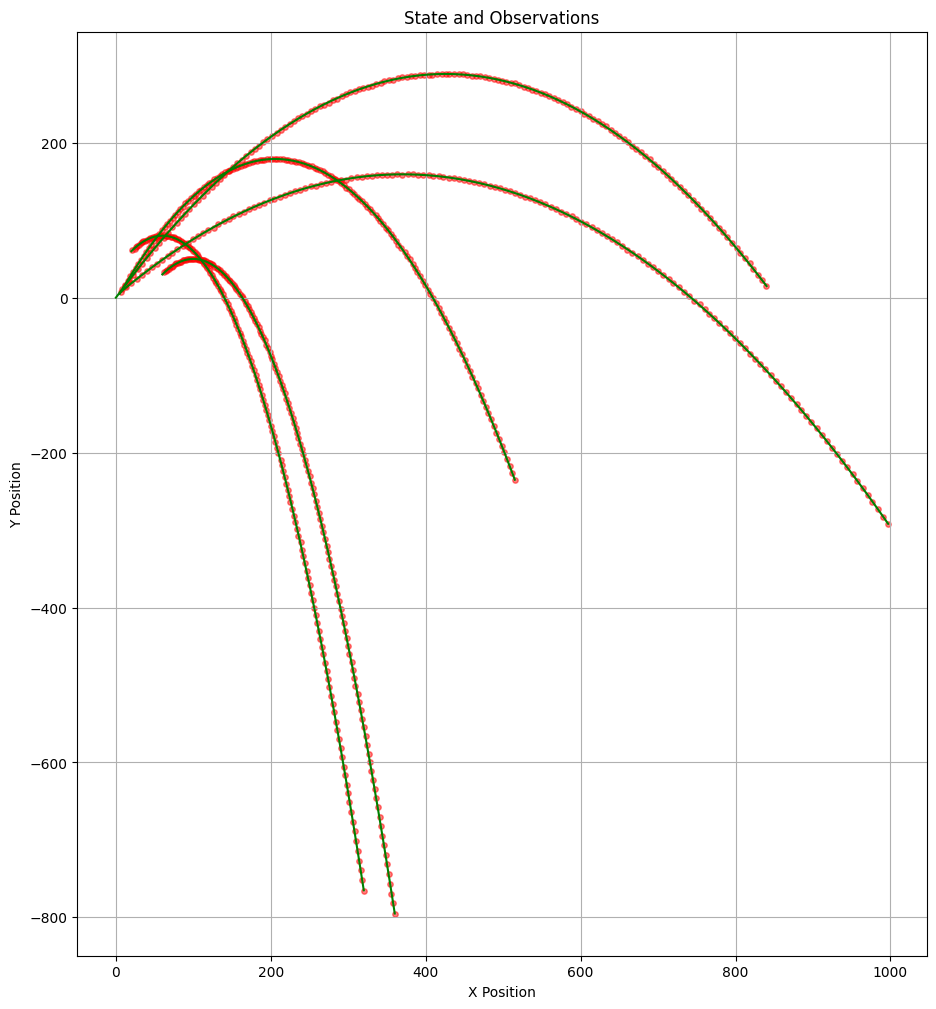

In [28]:
# Init start point
init_state = np.array([[0, 0, 56, 76], 
                      [5, 5, 34, 59], 
                      [7, 8, 66, 55],
                      [20, 60, 20, 20],
                      [60, 30, 20, 20]],
                      dtype=float).T
print(init_state)
simulator = BallThrowingSimulator(delta_t=delta_t, init_state=init_state[:,0:ball_num], ball_num=ball_num, observ_model=observ_model)
# Simulate the motion and observations
states, observations = simulator.simulate(time=15)
print(states.shape, observations.shape)
# Show the simulated states and observations
fig, ax = plt.subplots(figsize=(12, 12))
plot_observations(ax, states, observations)
plt.show()

# Initilaize
## State
$$[X, Y, V_x, V_y]^T$$

## Uniform Random Particle Sets
$$X, Y \in [0, 50]$$
$$V_x, V_y \in [0, 50]$$

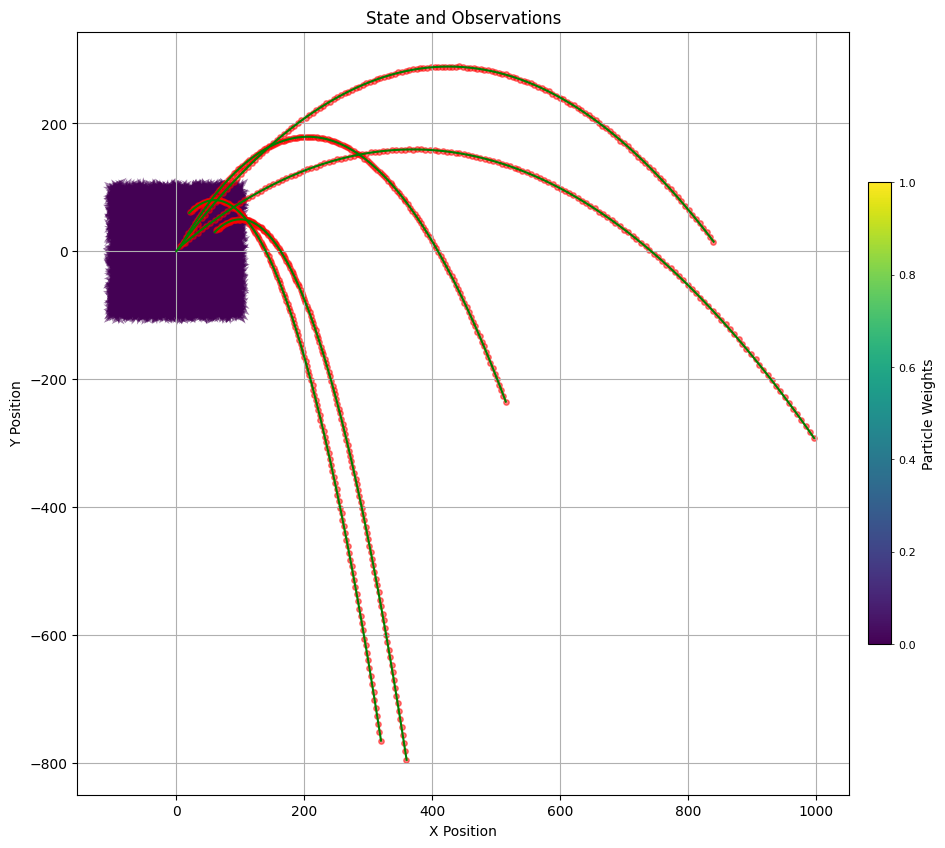

In [29]:
from partickle_filter import ParticleFilter
from transition_models import TransitionType
pf = ParticleFilter(delta_t, 40000, 1,TransitionType.Normal, observ_model, pos_range=[-100, 100], speed_range=[-80, 80])

init_particles, init_weights = pf.init_particles, pf.init_weights

# show initial particles
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_xlim(0, 3000)
# ax.set_ylim(0, 3000)
ax.set_title('Initial Particles')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plot_particles(ax, init_particles, init_weights)
plot_observations(ax, states, observations)
plt.show()

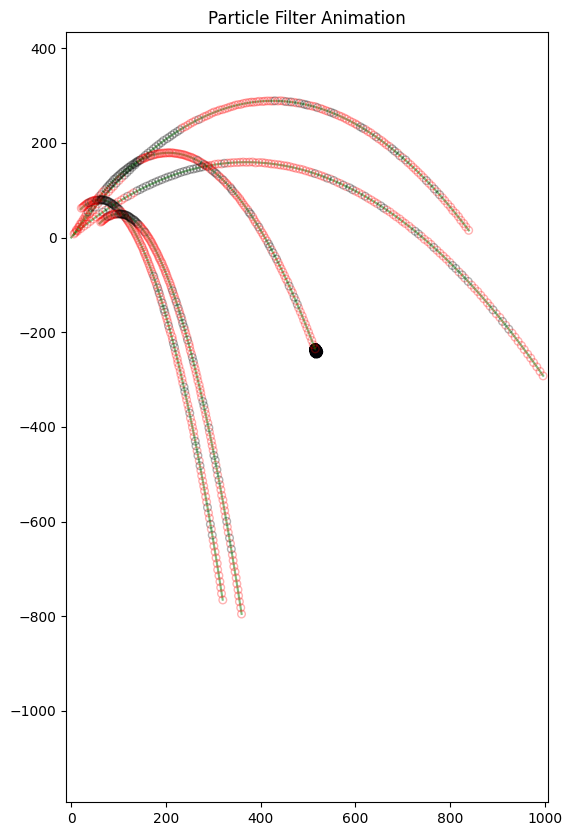

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from IPython.display import clear_output, display
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import logging

# 假设已有变量: states, observations, pf（含 pf.snaps、pf.update）

# 输出目录
os.makedirs("outputs", exist_ok=True)

# 初始化画布
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Particle Filter Animation")
print(states.shape, observations.shape)
all_x = np.concatenate((states[:, 0], observations[:, 0]))
all_y = np.concatenate((states[:, 1], observations[:, 1]))
x_min, x_max = np.min(all_x) - 10, np.max(all_x) + 10
y_min, y_max = 1.5*np.min(all_y), 1.5 * np.max(all_y)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')


# 初始化粒子状态
particles, weights = pf.init_particles, pf.init_weights

# use log norm to visulize weights
norm = LogNorm(vmin=1e-4, vmax=1e-1)  # 你可以根据权重范围调整

colormap_names = list(plt.colormaps.keys())[0:2*ball_num:2]
sms = [ScalarMappable(norm=norm, cmap=plt.get_cmap(name)) for name in colormap_names]

quivers = []
observ_slots = []
state_slots = []

for i in range(1):
    # 初始化绘图对象
    particles_quiver = ax.quiver(particles[:,0, i], particles[:, 1, i], 
                                particles[:, 2, i], particles[:, 3, i], 
                                color = sms[i].to_rgba(weights),
                                angles='xy', scale_units='xy', scale=13, width=0.0005)
    quivers.append(particles_quiver)

for i in range(ball_num):
    obs_sc = ax.scatter([], [], s=30, marker='o', facecolors='none', edgecolors='black', alpha=0.3, zorder=5) # s is marker size
    observ_slots.append(obs_sc)
    true_state_plot, = ax.plot(states[0, 0, i], states[0, 1, i], 'g-', label='True State', alpha=0.5)
    state_slots.append(true_state_plot)

    # draw clor bar
    # cbar = plt.colorbar(sms[i], ax=ax, shrink=0.5, pad=0.02)
    # cbar.set_label(f'Particle Weights {i}')
    # # make colorbar smaller
    # cbar.ax.tick_params(labelsize=8, length=2, width=0.2)

# plt.legend()

plt.savefig(f"outputs/frame_000.png", dpi=150)
display(fig)

# to show if observation is none
observ_colors = [(1.,0.,0.,1.)]*observations.shape[0]
has_no_observs = np.array([False]*observations.shape[0])
print(observ_colors[:2])
print(sms[0].to_rgba(weights).shape)

has_no_observs[20:40] = True

has_observ_thresh = 0.8
for frame in range(1, states.shape[0]):
    # set observation to none in 50% probability
    non_observ_chance = np.random.rand()
    has_no_observ = has_no_observs[frame-1] or non_observ_chance>has_observ_thresh
    observ = observations[frame-1]
    if has_no_observ:
        observ_colors[frame-1] = [0.,0.,0.,1.]
        observ = None
    particles, weights = pf.update(particles, weights, observ)

    for i in range(1):
        particles_quiver  = quivers[i]

        particles_quiver.set_offsets(particles[:, :2, i])
        particles_quiver.set_UVC(particles[:, 2, i], particles[:, 3, i])
        particles_quiver.set_color(sms[i].to_rgba(weights))
        
    for i in range(ball_num):
        obs_sc, true_state_plot = observ_slots[i], state_slots[i]
        true_state_plot.set_data(states[:frame+1, 0, i], states[:frame+1, 1, i])

        obs_sc.set_offsets(observations[:frame, :, i])
        obs_sc.set_edgecolors(observ_colors[:frame])

    clear_output(wait=True)
    display(fig)
    # 保存帧
    plt.savefig(f"outputs/frame_{frame:03d}.png", dpi=150)

# plt.close(fig)  # 完成后关闭图形
plt.ioff()
plt.close(fig)

# save to gif
gif_frames = [Image.open(f"outputs/frame_{frame:03d}.png") for frame in range(states.shape[0])]
gif_path = "outputs/particle_filter_animation.gif"
gif_frames[0].save(gif_path, save_all=True, append_images=gif_frames[1:], duration=300, loop=0)
